TOC

- [Run Stan](#Run-Stan-model)
- [Post process](#Post-process)
    - [HMC](#HMC)
    - [Pair plots](#Pair-plots)
    - [Phase spaces](#Phase-spaces)
    - [PPC sEEG](#PPC-sEEG)

In [1]:
%pylab inline
# comment on lofi screen
%config InlineBackend.figure_format = 'retina'
import lib
lib.cmdstan_path('~/cmdstan-2.17.0');

Populating the interactive namespace from numpy and matplotlib


## Run Stan model

Compile first,

In [2]:
lib.compile_model('vep-fe-rev-05.stan')

make: `/Users/maedoc/Sources/TVB/VEP/vep-fe-rev-05' is up to date.


Run multiple chains,

In [4]:
%%bash
model=vep-fe-rev-05
rm -f ${model}.optimize.*.{out,csv}

for i in `seq 4`
do
    j=0
    while ! ./$model id=$((100*$j + $i)) \
        optimize \
        data file=data.R \
        output file=${model}.optimize.$i.csv refresh=10 \
        &> ${model}.optimize.$i.out
    do
        j=$(($j + 1))
        echo "trying again.. (j=$j)"
    done
done

Check all optimizations OK

In [5]:
!tail -n2 *optimize*out

==> vep-fe-rev-05.optimize.1.out <==
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

==> vep-fe-rev-05.optimize.2.out <==
Optimization terminated normally: 
  Maximum number of iterations hit, may not be at an optima

==> vep-fe-rev-05.optimize.3.out <==
Optimization terminated normally: 
  Maximum number of iterations hit, may not be at an optima

==> vep-fe-rev-05.optimize.4.out <==
Optimization terminated normally: 
  Maximum number of iterations hit, may not be at an optima


Convert optimizations to R format

In [3]:
for i in range(1, 5):
    csv = lib.parse_csv(f'vep-fe-rev-05.optimize.{i}.csv')
    data = {k: v[0] for k, v in csv.items()}
    # bug in my rdump or stan file..
    data['x_eta'] = data['x_eta'].T
    data['z_eta'] = data['z_eta'].T
    lib.rdump(f'vep-fe-rev-05.optimize.{i}.csv.R', data)

Now run MC chains

In [ ]:
%%bash
model=vep-fe-rev-05
rm -f ${model}.sample.*.{out,csv}
for i in `seq 2`
do
    ./$model id=$i\
        sample save_warmup=1 num_warmup=200 num_samples=200 \
            adapt \
                delta=0.8 \
            algorithm=hmc \
                engine=nuts \
                    max_depth=7 \
        data file=data.R \
        output file=${model}.sample.$i.csv refresh=1 \
        &> ${model}.sample.$i.out &
done

Check status..

In [5]:
!tail -n 1 vep-fe-rev-05.sample.*.out
csv = lib.io.stan.parse_csv('vep-fe-rev-05.sample.*.csv', merge=False)

==> vep-fe-rev-05.sample.1.out <==


==> vep-fe-rev-05.sample.2.out <==



Maybe stop them if required..

In [52]:
!killall vep-fe-rev-05

## Post process

_Often I'm running next version of model while analyzing previous version, so it's helpful to note git hash_

In [273]:
!git rev-parse HEAD

010bc9b9f27e644a465ecfd7ea244a91d9a1f2a4


### HMC

Plot HMC stats (while running)

/Users/maedoc/miniconda3/envs/scipy/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


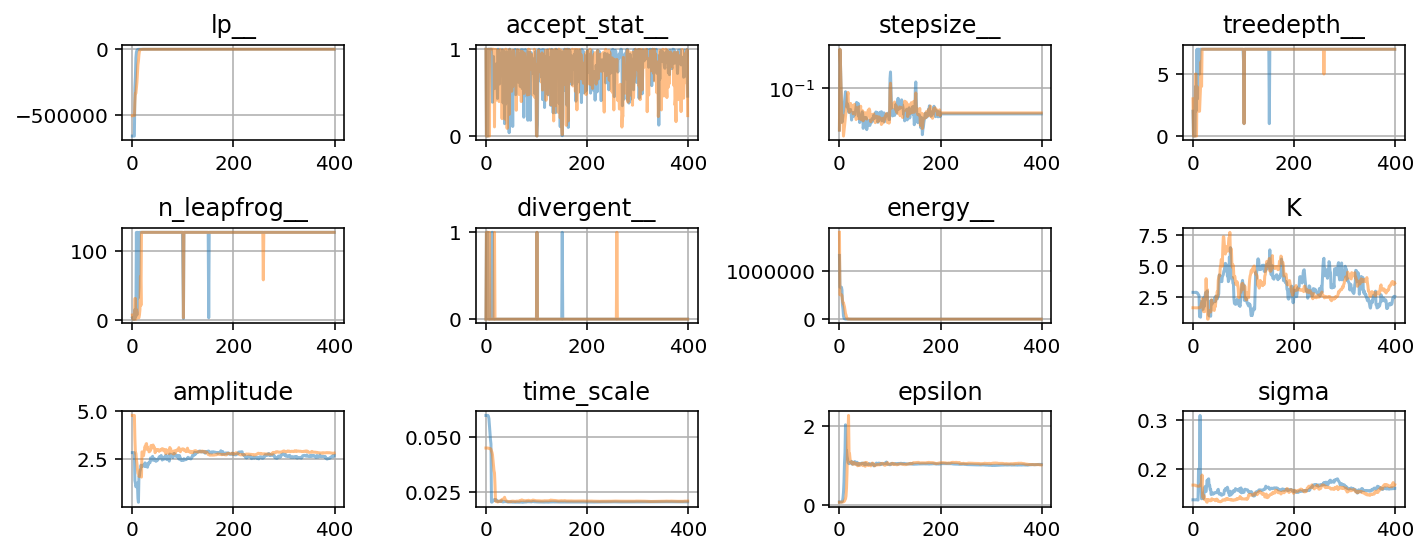

In [4]:
figure(figsize=(10, 5))
extras = 'K time_scale sigma epsilon amplitude'.split()
lib.trace_nuts(csv, extras)
tight_layout()

### Pair plots

_Skip 150 warmup samples, plot different chains by color_

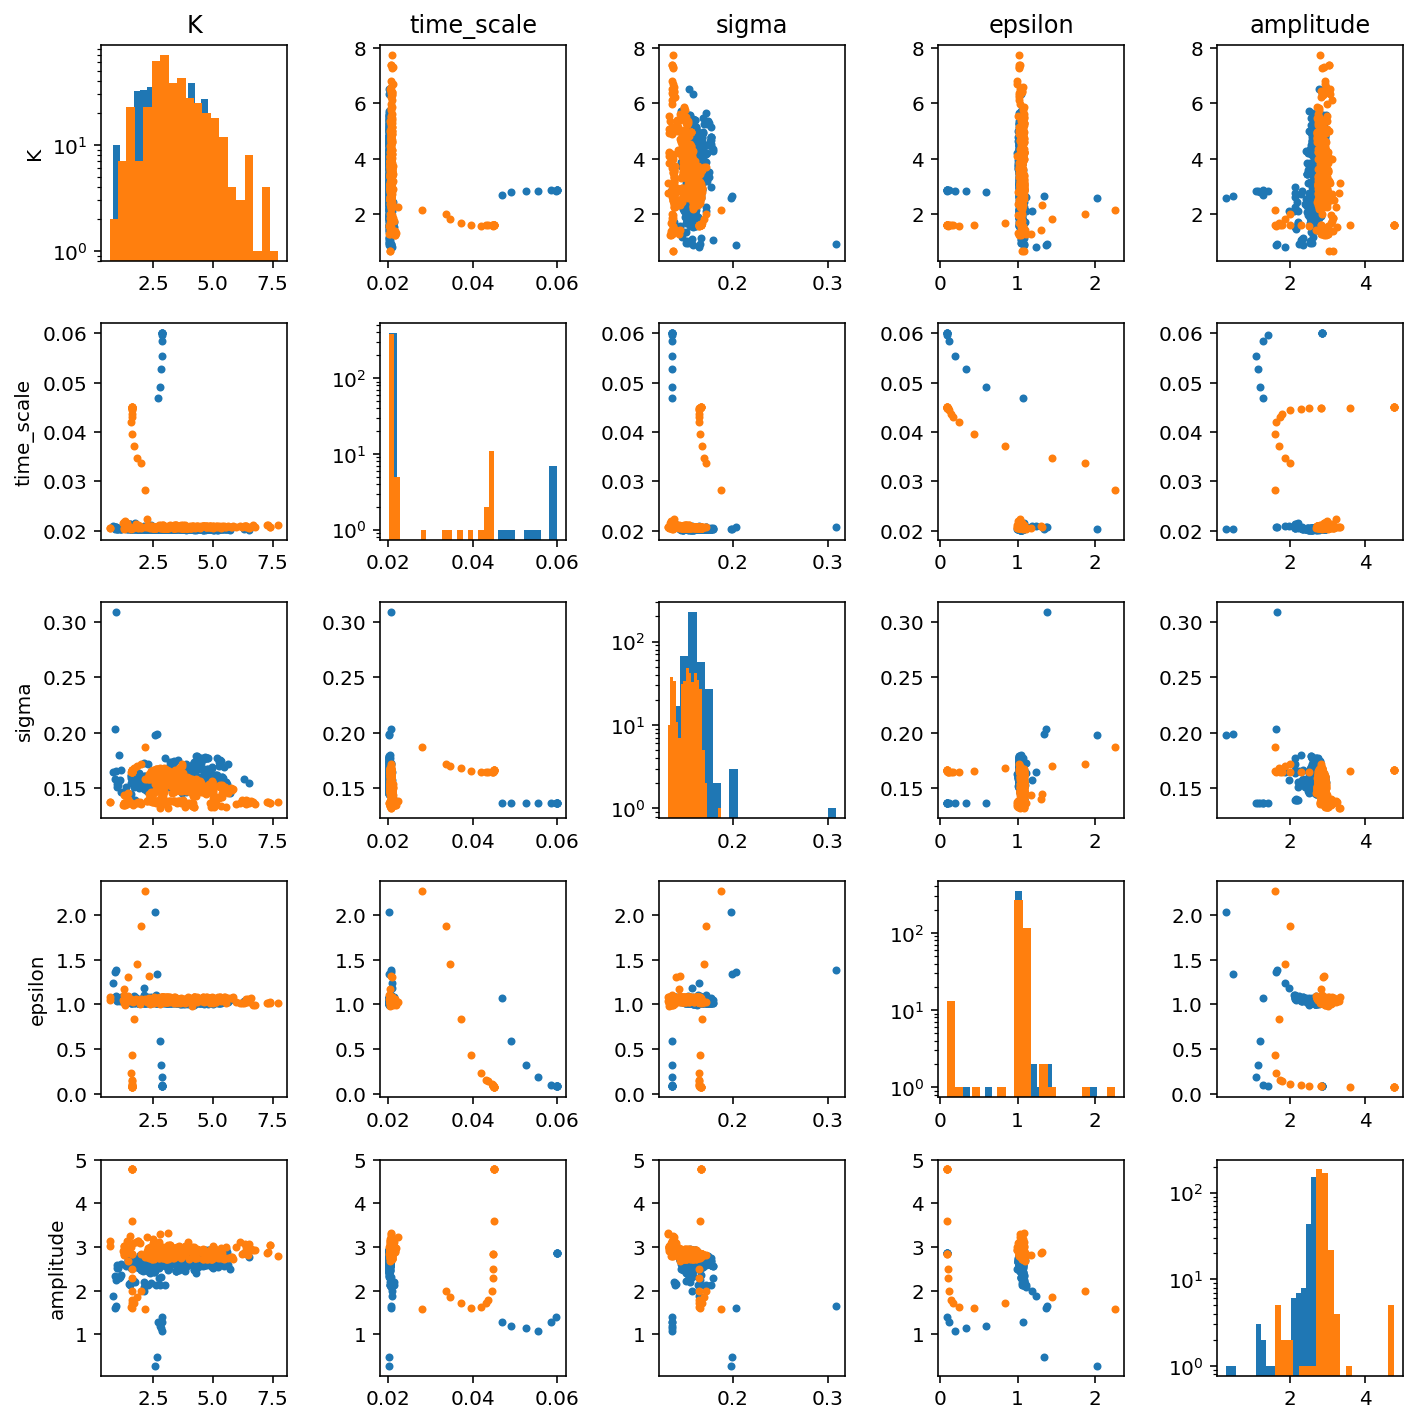

In [7]:
figure(figsize=(10, 10))
lib.pair_plots(csv, extras, skip=0)

### Phase spaces

Phase space plots tell about the linear/nonlinear behavior of the neural mass model.  Specifically, the model predicts transition between healthy and seizure states when `x` passes from negative knee to positive knee.

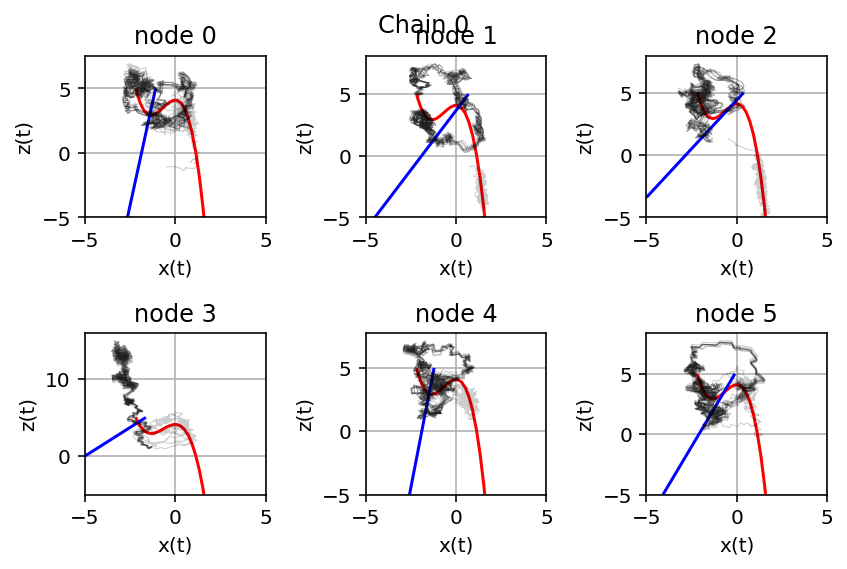

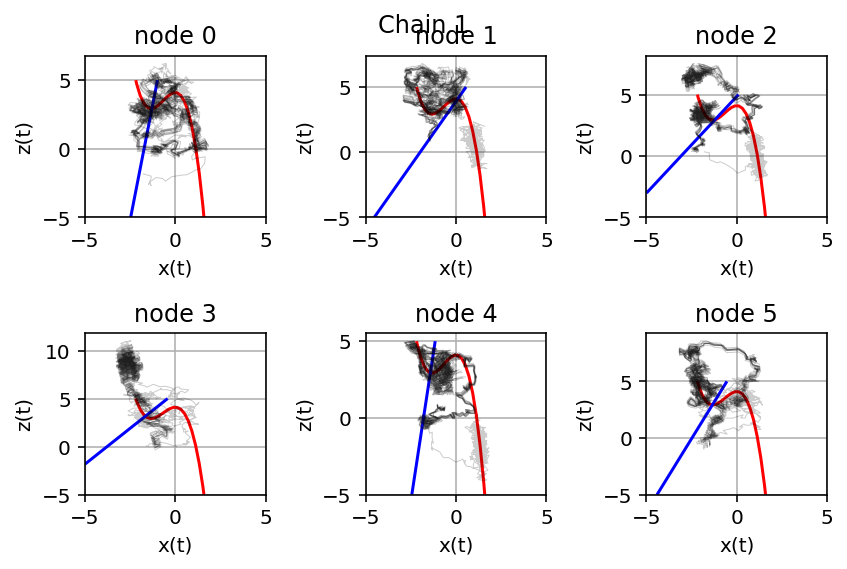

In [4]:
for i, csvi in enumerate(csv):
    figure()
    lib.phase_space(csvi)
    suptitle(f'Chain {i}')
    tight_layout()

Some chains were running into instability with linear `k * gx` coupling, now much more stable with `tanh(k * gx)`.

### PPC sEEG

Posterior predictive traces for observation,

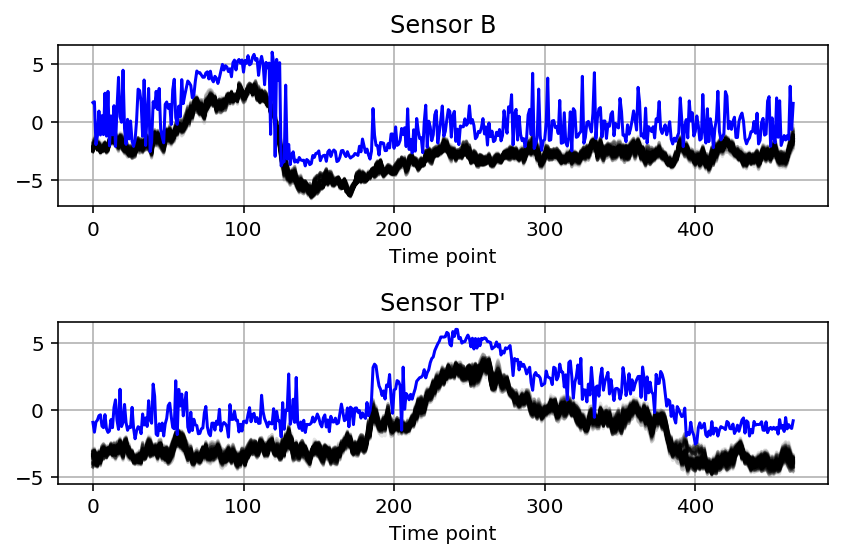

In [3]:
lib.ppc_seeg(csv[1], skip=200)
tight_layout()

### X0 values

Excitability estimates per region, parameter of interest

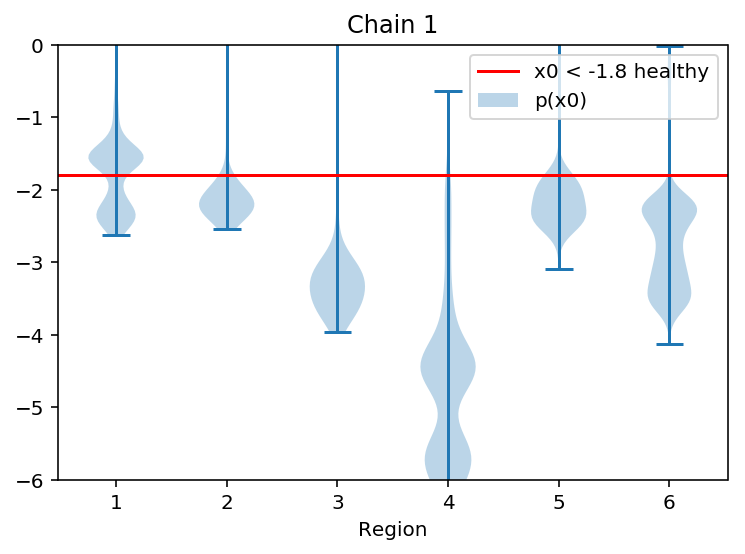

In [3]:
lib.violin_x0(csv)

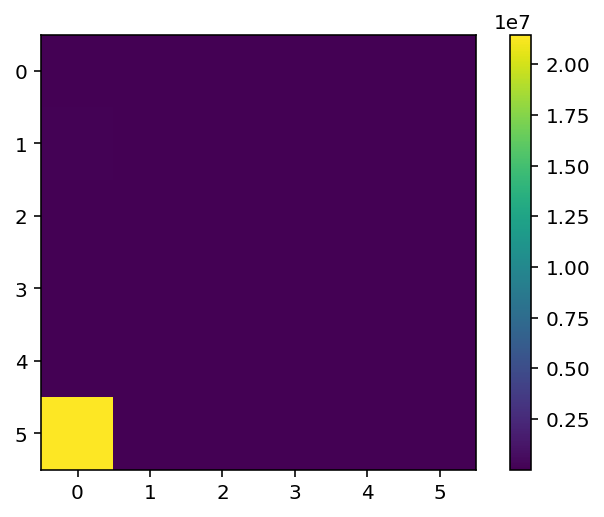

In [8]:
imshow(csv[0]['FC'].mean(axis=0))
colorbar()